In [1]:
#| default_exp core

In [2]:
#| export

import kagglehub

import os
import io
import re
import random
import base64
from io import BytesIO

import time
from datetime import timedelta

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from IPython.display import SVG

from PIL import Image
import cv2

from diffusers import StableDiffusionPipeline
from transformers import AutoProcessor, AutoModel

2025-05-08 07:09:19.427097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746688159.677696      49 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746688159.749598      49 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import pandas as pd
import json

In [4]:
drawing_with_llms_path = kagglehub.competition_download('drawing-with-llms')
train_df = pd.read_csv(f'{drawing_with_llms_path}/train.csv')
train_question_df = pd.read_parquet(f'{drawing_with_llms_path}/questions.parquet')

In [5]:
train_question_df = train_question_df.groupby('id').apply(lambda df: df.to_dict(orient='list'))
train_question_df = train_question_df.reset_index(name='qa')

train_question_df['question'] = train_question_df.qa.apply(lambda qa: json.dumps(qa['question'], ensure_ascii=False))

train_question_df['choices'] = train_question_df.qa.apply(
    lambda qa: json.dumps(
        [x.tolist() for x in qa['choices']], ensure_ascii=False
    )
)

train_question_df['answer'] = train_question_df.qa.apply(lambda qa: json.dumps(qa['answer'], ensure_ascii=False))

train_df = pd.merge(train_df, train_question_df, how='left', on='id')

train_df['multiple_choice_qa'] = train_df.apply(
    lambda r: {
    'question': json.loads(r.question),
    'choices': json.loads(r.choices),
    'answer': json.loads(r.answer)
    },
    axis=1,
)

train_df.head()

/tmp/ipykernel_49/3218796089.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_question_df = train_question_df.groupby('id').apply(lambda df: df.to_dict(orient='list'))


id                                        description  \
0  02d892                            a purple forest at dusk   
1  0dcd2e              gray wool coat with a faux fur collar   
2  1e9ac1                 a lighthouse overlooking the ocean   
3  2b25db  burgundy corduroy pants with patch pockets and...   
4  4e6a54                           orange corduroy overalls   

                                                  qa  \
0  {'id': ['02d892', '02d892', '02d892', '02d892'...   
1  {'id': ['0dcd2e', '0dcd2e', '0dcd2e', '0dcd2e'...   
2  {'id': ['1e9ac1', '1e9ac1', '1e9ac1', '1e9ac1'...   
3  {'id': ['2b25db', '2b25db', '2b25db', '2b25db'...   
4  {'id': ['4e6a54', '4e6a54', '4e6a54', '4e6a54'...   

                                            question  \
0  ["What is the main setting of the image?", "Is...   
1  ["What color is the coat?", "What part of the ...   
2  ["Is there an ocean visible in the image?", "W...   
3  ["Are the pants yellow?", "Do the pants have p...   
4  ["What material is the item?", "Is a hat depic...   

                                             choices  \
0  [["beach", "desert", "forest", "mountain"], ["...   
1  [["blue", "brown", "gray", "red"], ["collar", ...   
2  [["no", "yes"], ["inside", "next to", "overloo...   
3  [["no", "yes"], ["no", "yes"], ["no", "yes"], ...   
4  [["corduroy", "denim", "leather", "silk"], ["n...   

                                  answer  \
0    ["forest", "yes", "dusk", "purple"]   
1       ["gray", "collar", "no", "wool"]   
2     ["yes", "overlooking", "no", "no"]   
3          ["no", "yes", "yes", "pants"]   
4  ["corduroy", "no", "yes", "overalls"]   

                                  multiple_choice_qa  
0  {'question': ['What is the main setting of the...  
1  {'question': ['What color is the coat?', 'What...  
2  {'question': ['Is there an ocean visible in th...  
3  {'question': ['Are the pants yellow?', 'Do the...  
4  {'question': ['What material is the item?', 'I...

In [6]:
#| export

class Model:
    def __init__(self):
        self.model = kagglehub.package_import('nicecaliforniaw/stablediffusionmodel/versions/7').Model()

    def predict(self, prompt: str) -> str:
        svg = self.model.predict(prompt)
        return svg

    def predict_impl(self, prompt: str) -> str:
        svg, img = self.model.predict_impl(prompt)
        return svg, img

In [7]:
model = Model()

Installing python dependencies for Package 'kagglehub_package_nicecaliforniaw_stablediffusionmodel_7', logging progress to '/tmp/kagglehub-package-dependencies-install-b35wiy2d.txt'.
Using device: cuda:1


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [8]:
import matplotlib.pyplot as plt

import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

In [9]:
train_df.iloc[14]['description']

'a maroon dodecahedron interwoven with teal threads'

In [10]:
train_df.head()

id                                        description  \
0  02d892                            a purple forest at dusk   
1  0dcd2e              gray wool coat with a faux fur collar   
2  1e9ac1                 a lighthouse overlooking the ocean   
3  2b25db  burgundy corduroy pants with patch pockets and...   
4  4e6a54                           orange corduroy overalls   

                                                  qa  \
0  {'id': ['02d892', '02d892', '02d892', '02d892'...   
1  {'id': ['0dcd2e', '0dcd2e', '0dcd2e', '0dcd2e'...   
2  {'id': ['1e9ac1', '1e9ac1', '1e9ac1', '1e9ac1'...   
3  {'id': ['2b25db', '2b25db', '2b25db', '2b25db'...   
4  {'id': ['4e6a54', '4e6a54', '4e6a54', '4e6a54'...   

                                            question  \
0  ["What is the main setting of the image?", "Is...   
1  ["What color is the coat?", "What part of the ...   
2  ["Is there an ocean visible in the image?", "W...   
3  ["Are the pants yellow?", "Do the pants have p...   
4  ["What material is the item?", "Is a hat depic...   

                                             choices  \
0  [["beach", "desert", "forest", "mountain"], ["...   
1  [["blue", "brown", "gray", "red"], ["collar", ...   
2  [["no", "yes"], ["inside", "next to", "overloo...   
3  [["no", "yes"], ["no", "yes"], ["no", "yes"], ...   
4  [["corduroy", "denim", "leather", "silk"], ["n...   

                                  answer  \
0    ["forest", "yes", "dusk", "purple"]   
1       ["gray", "collar", "no", "wool"]   
2     ["yes", "overlooking", "no", "no"]   
3          ["no", "yes", "yes", "pants"]   
4  ["corduroy", "no", "yes", "overalls"]   

                                  multiple_choice_qa  
0  {'question': ['What is the main setting of the...  
1  {'question': ['What color is the coat?', 'What...  
2  {'question': ['Is there an ocean visible in th...  
3  {'question': ['Are the pants yellow?', 'Do the...  
4  {'question': ['What material is the item?', 'I...

In [11]:
train_df['raw_res'] = train_df.description.progress_apply(model.predict_impl)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [12]:
train_df['svg'] = train_df.raw_res.apply(lambda x: x[0])
train_df['bitmap'] = train_df.raw_res.apply(lambda x: x[1])

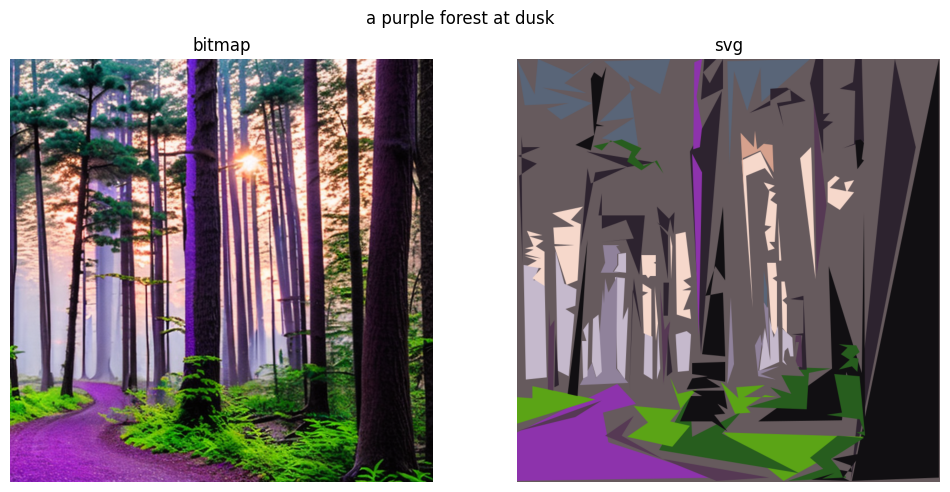

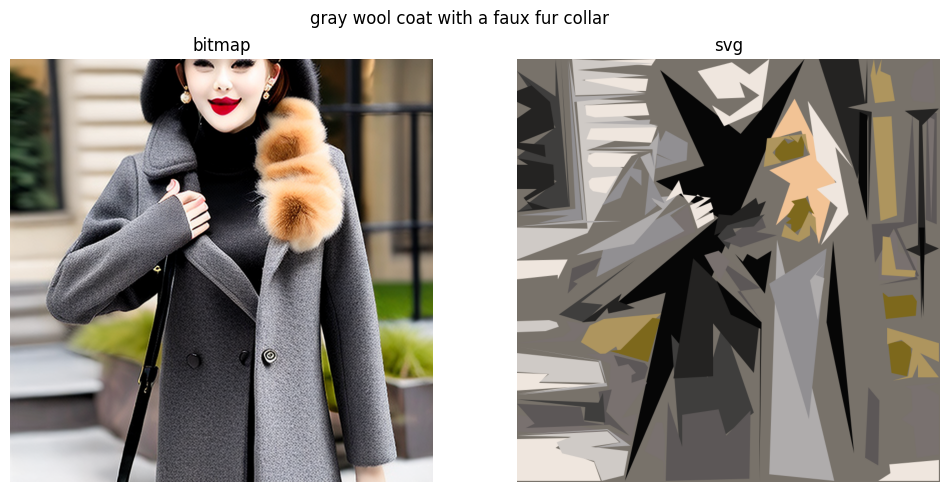

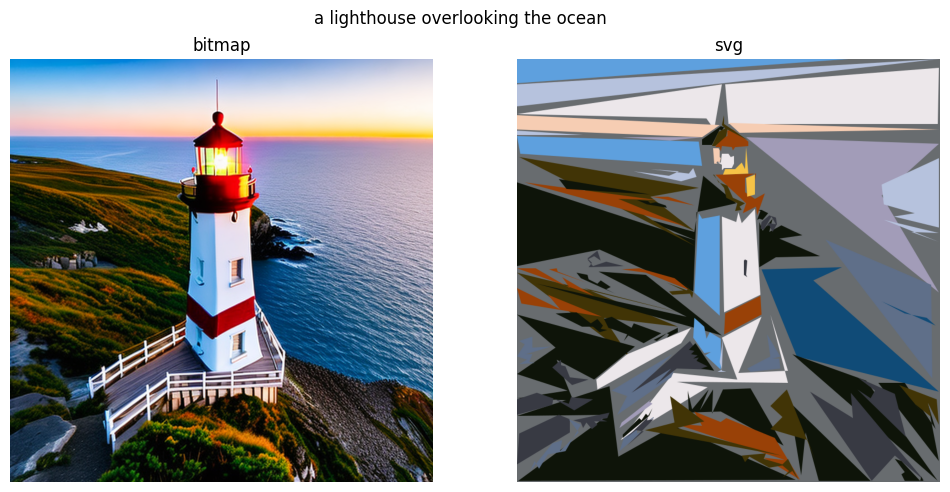

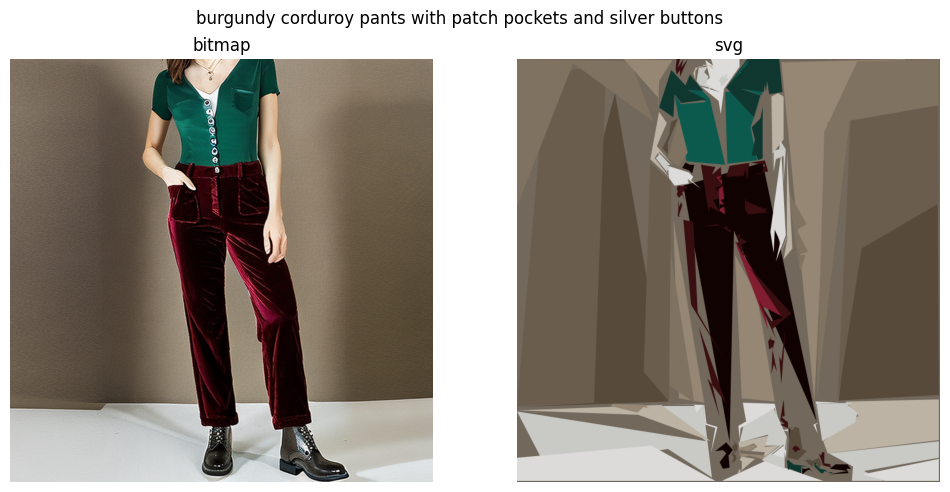

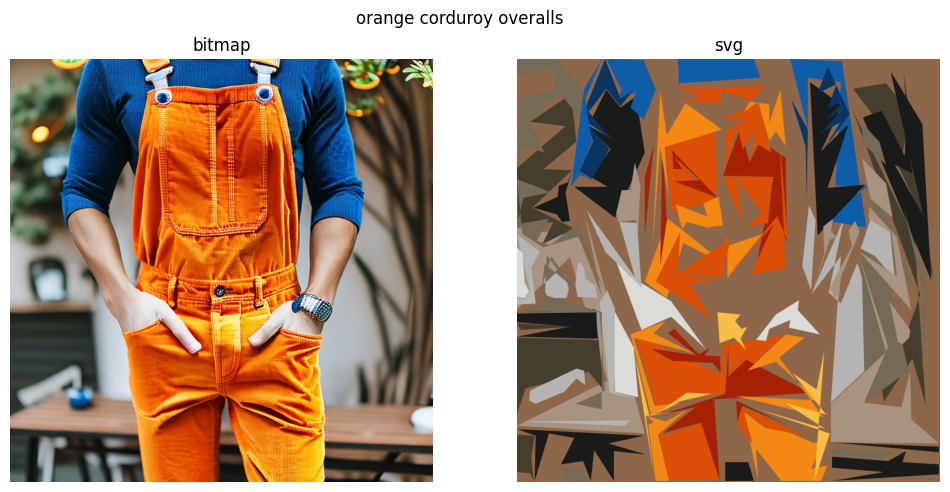

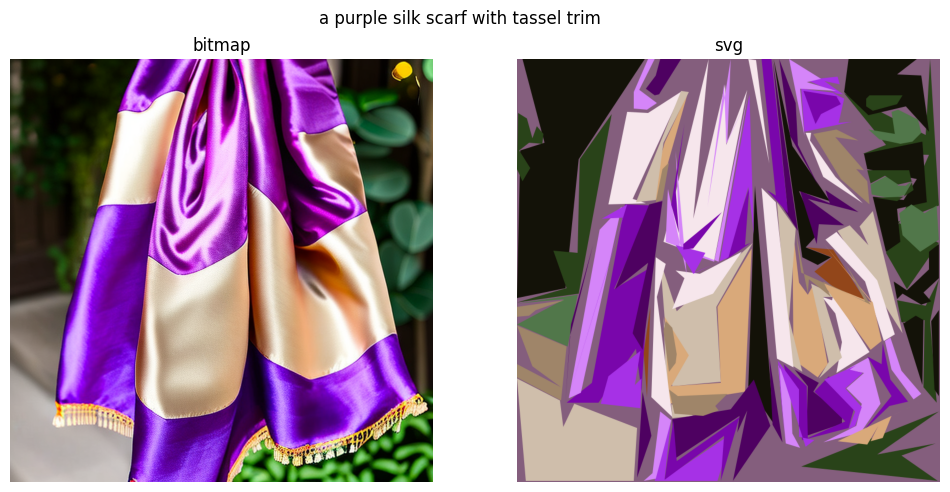

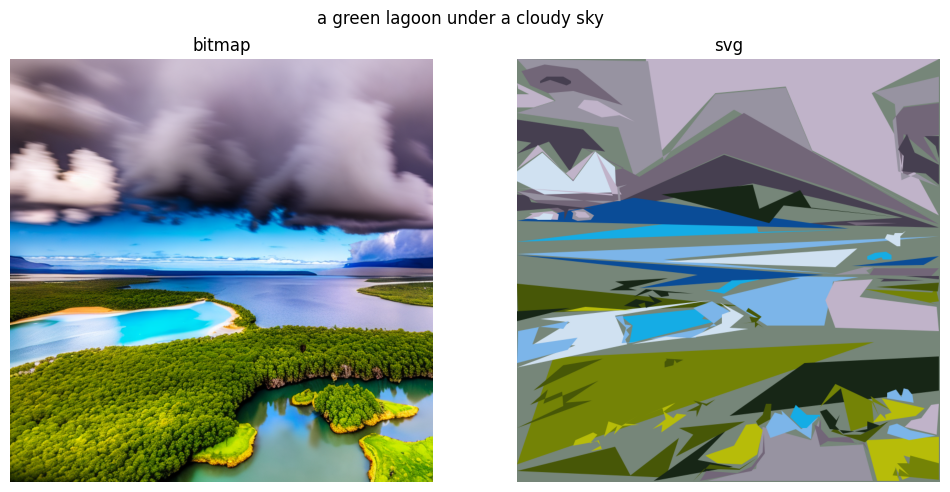

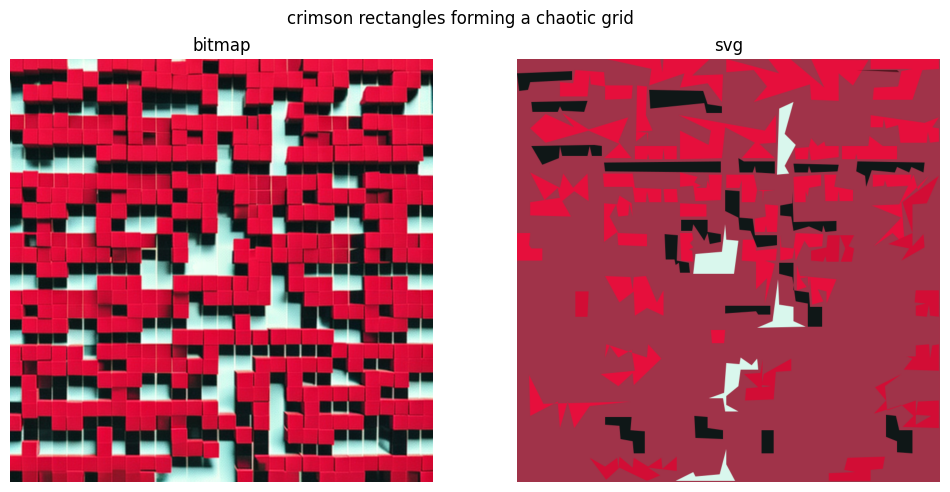

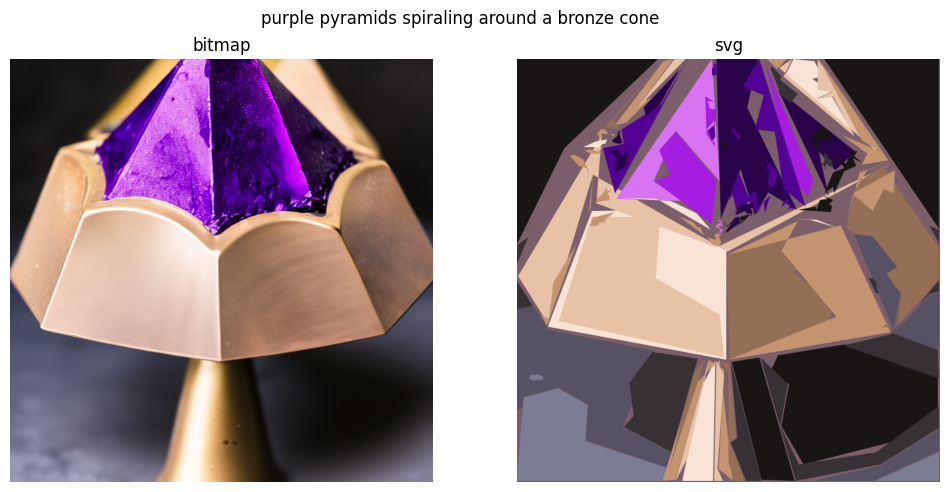

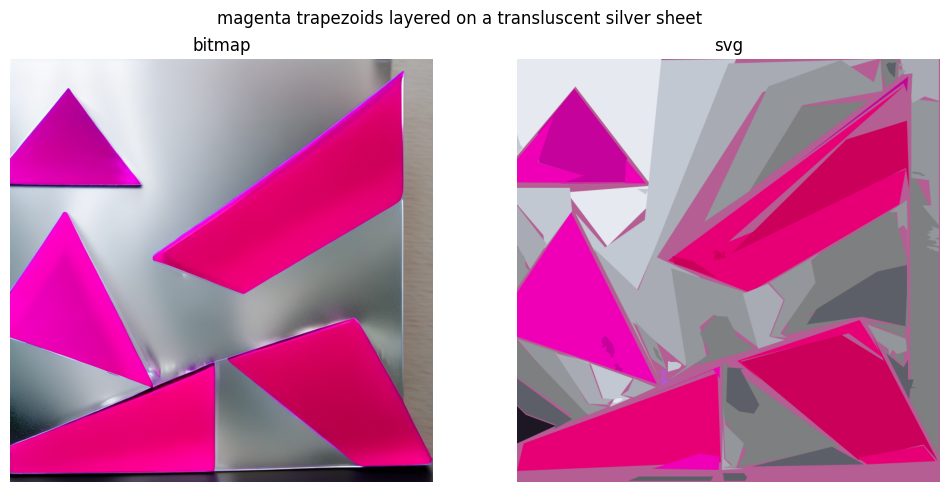

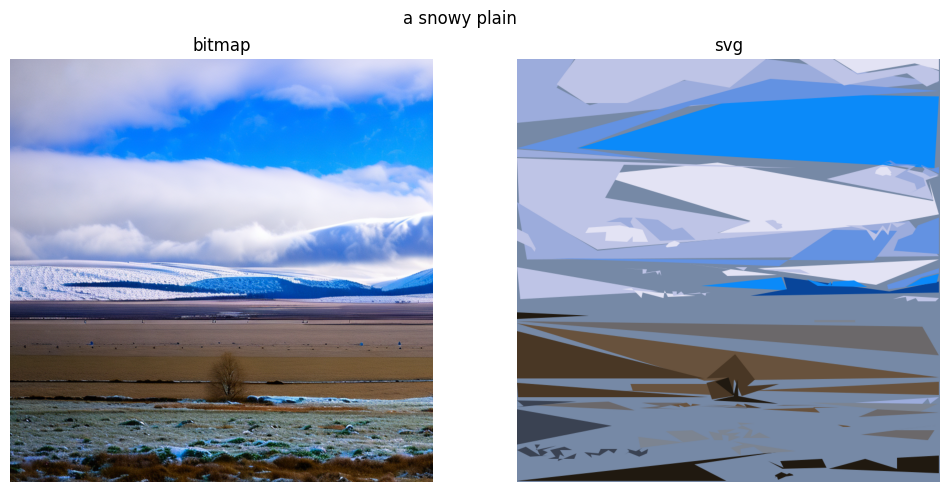

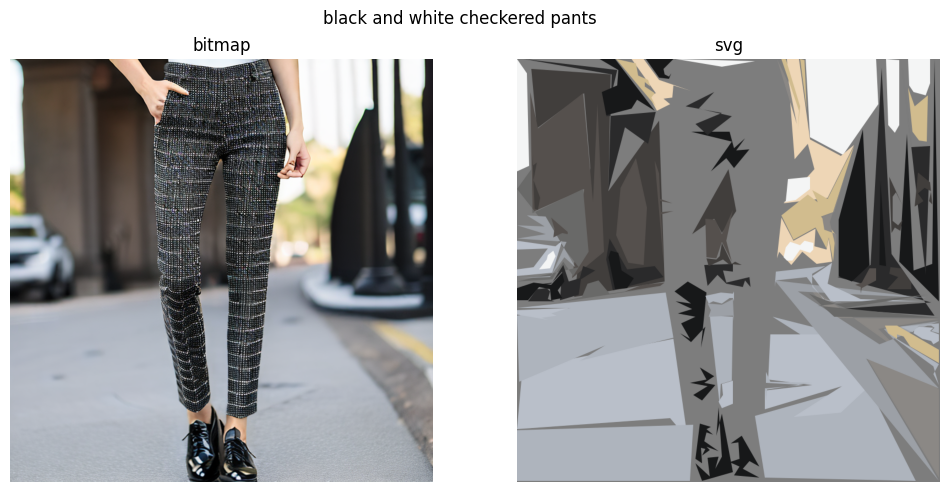

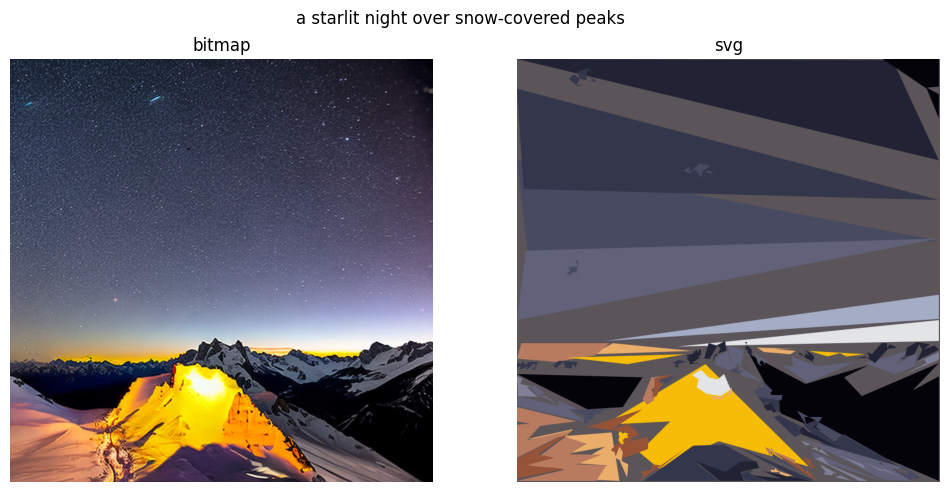

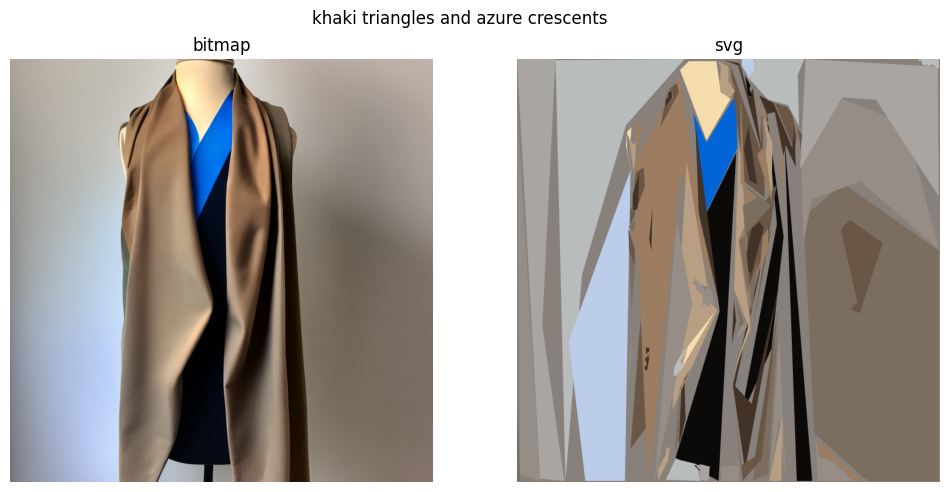

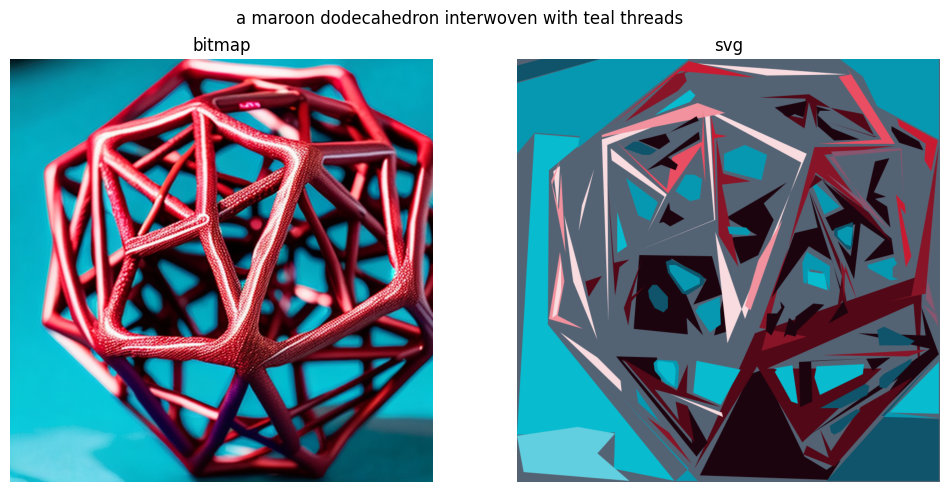

In [13]:
import cairosvg

for r in train_df.itertuples():
    
    plt.figure(figsize=(12, 6))
    plt.suptitle(r.description, y=0.93)
    
    plt.subplot(1, 2, 1)
    plt.imshow(np.array(r.bitmap))
    plt.axis('off')
    plt.title(f'bitmap')

    plt.subplot(1, 2, 2)
    png_bytes = cairosvg.svg2png(bytestring=r.svg.encode('utf-8'))
    img = Image.open(io.BytesIO(png_bytes))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'svg')